In [1]:
import numpy as np
import torch
# Local utilities
from utils import (
    load_data,
    plot_true_vs_pred,
)
from metric import (
    compute_effect,
    compute_metric,
)
from simulation import (
    simulate_treatment,
    compute_outcome,
)
from train import (
    GraphData,
    TrainConfig,
    PropensityConfig,
    MeanConfig,
    AttentionConfig,
    fit_propensity,
    fit_mean,
    fit_attention,
)

In [2]:
# Data_path "Flickr_New.npz" or "BC_New.npz"
path="Flickr_New.npz"
# Feature name lda_10, lda_5, pca_10, pca_5, lda_supervised
feature_name="lda_supervised"
# Fold number 0,1,2,3,4
fold_num=2
X,A,X_val,A_val,X_test,A_test=load_data(path,feature_name,fold_num)

In [19]:
# Larger, propensity score more extreme to 0 or 1
beta=1
# Larger, propensity score shift to 1
alpha=2
# Larger, more weight on larger attention
attn_temperature=0
# Noise level
sigma=0.05
# Larger, higher spillover effect/base effect
scale=5
# Attention type "cosine" or "rbf" or "homo" or "heter"
attention_type="cosine"
# Num of num_partitions
num_partition=3
# Train
nbrs_idx, n, d, partitions, t, e_star, treat_neighbor, treat_matrix=simulate_treatment(X, A, mode="train",beta=beta, alpha=alpha,num_partitions=num_partition)
true_attention, spillover, U_0, noise, y, m_star =\
 compute_outcome(X, A, treat_matrix, e_star, n, sigma, scale, attn_temperature,attention_type)
IME, ISE, ITE = compute_effect(true_attention, A)

# Test
nbrs_idx_test, n_test, d_test, partitions_test, t_test, e_star_test, treat_neighbor_test, treat_matrix_test=\
  simulate_treatment(X_test, A_test,mode="test",beta=beta, alpha=alpha)
true_attention_test, spillover_test, U_0_test, noise_test, y_test, m_star_test =\
 compute_outcome(X_test, A_test, treat_matrix_test, e_star_test, n_test, sigma, scale, attn_temperature,attention_type)
IME_test, ISE_test, ITE_test = compute_effect(true_attention_test, A_test)

In [ ]:
# Training configs
# Use this config for propensity and mean models
train_cfg_pm = TrainConfig(epochs=100, lr=1e-3, batch_size=64, patience=12, device="cpu")

prop_cfg = PropensityConfig(hidden_dim=128)
mean_cfg = MeanConfig(hidden_dim=128)
attn_cfg = AttentionConfig(hidden_dim=64, attn_temperature=attn_temperature)

data = GraphData(X=X, y=y, A=A, nbrs_idx=nbrs_idx, t=t, fold_assignments=partitions)

fr_p, data = fit_propensity(data, train_cfg_pm, prop_cfg)
fr_m, data = fit_mean(data, train_cfg_pm, mean_cfg)


[propensity] Fold 0, Epoch 001 | train: 0.688589 | fold_loss: 0.675891
[propensity] Fold 0, Epoch 002 | train: 0.678680 | fold_loss: 0.666018
[propensity] Fold 0, Epoch 003 | train: 0.669023 | fold_loss: 0.656406
[propensity] Fold 0, Epoch 004 | train: 0.659619 | fold_loss: 0.647058
[propensity] Fold 0, Epoch 005 | train: 0.650470 | fold_loss: 0.637971
[propensity] Fold 0, Epoch 006 | train: 0.641575 | fold_loss: 0.629144
[propensity] Fold 0, Epoch 007 | train: 0.632935 | fold_loss: 0.620573
[propensity] Fold 0, Epoch 008 | train: 0.624548 | fold_loss: 0.612255
[propensity] Fold 0, Epoch 009 | train: 0.616411 | fold_loss: 0.604187
[propensity] Fold 0, Epoch 010 | train: 0.608523 | fold_loss: 0.596366
[propensity] Fold 0, Epoch 011 | train: 0.600882 | fold_loss: 0.588790
[propensity] Fold 0, Epoch 012 | train: 0.593483 | fold_loss: 0.581452
[propensity] Fold 0, Epoch 013 | train: 0.586324 | fold_loss: 0.574350
[propensity] Fold 0, Epoch 014 | train: 0.579402 | fold_loss: 0.567480
[prope

43.11291287699005
35.74379743823286


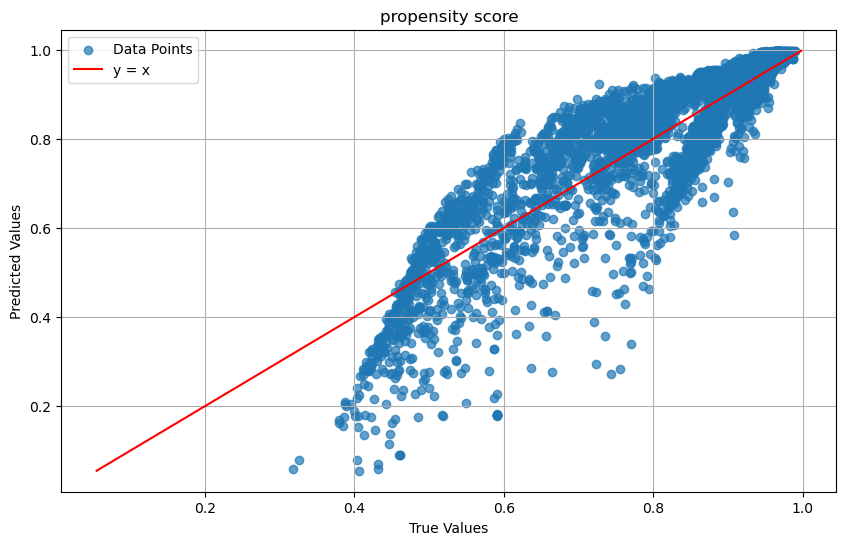

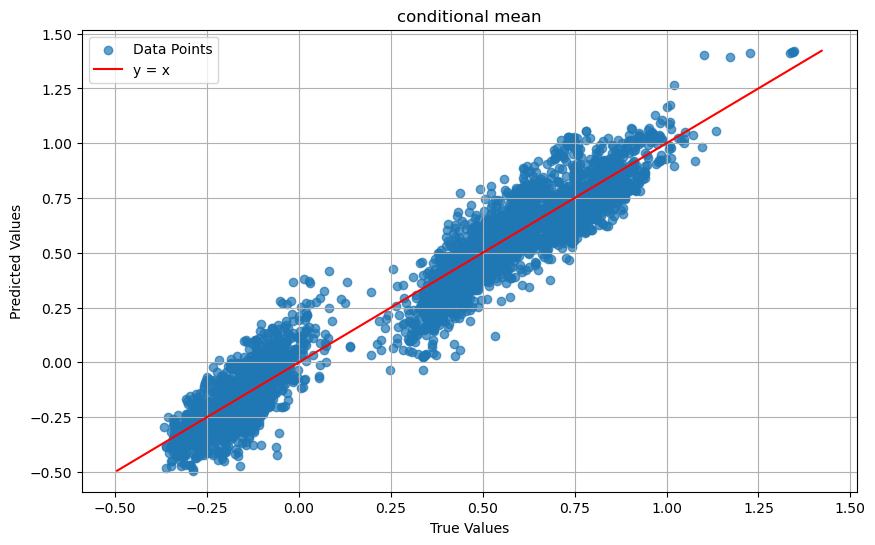

In [21]:
# Access fitted predictions via FitResult or updated GraphData
mu_hat = data.mu_hat
e_hat = data.e_hat

print(np.sum((mu_hat-m_star)**2))
print(np.sum((e_hat-e_star)**2))

plot_true_vs_pred(e_hat,e_star,title_name="propensity score")
plot_true_vs_pred(mu_hat,m_star,title_name="conditional mean")

In [ ]:
# Separate config for attention 
train_cfg_attn = TrainConfig(epochs=100, lr=1e-3, batch_size=64, patience=12, device="cpu")
fr_a      = fit_attention(data, train_cfg_attn, attn_cfg, attn_true=true_attention)

Epoch 001, New best Spillover diff: 58.4715
Epoch 002, New best Spillover diff: 38.4321
Epoch 003, New best Spillover diff: 35.5206
No improve. Epoch 004, Spillover diff: 46.0897
No improve. Epoch 005, Spillover diff: 67.4411
No improve. Epoch 006, Spillover diff: 78.4530
No improve. Epoch 007, Spillover diff: 89.8975
No improve. Epoch 008, Spillover diff: 141.2624
No improve. Epoch 009, Spillover diff: 140.3979
No improve. Epoch 010, Spillover diff: 164.7810
No improve. Epoch 011, Spillover diff: 225.7103
No improve. Epoch 012, Spillover diff: 207.2776
No improve. Epoch 013, Spillover diff: 184.6690
No improve. Epoch 014, Spillover diff: 255.3846
No improve. Epoch 015, Spillover diff: 206.5629
Stopping early at epoch 15 due to no improvement for 12 consecutive epochs.
Time taken: 18.72 seconds


Proposed: training set
IME: AME = 0.00839, PEHE = 0.03801
ISE: AME = 0.11248, PEHE = 0.16196
ITE: AME = 0.12088, PEHE = 0.17367
Proposed: testing set
IME: AME = 0.02017, PEHE = 0.10056
ISE: AME = 0.08603, PEHE = 0.15210
ITE: AME = 0.10620, PEHE = 0.19607


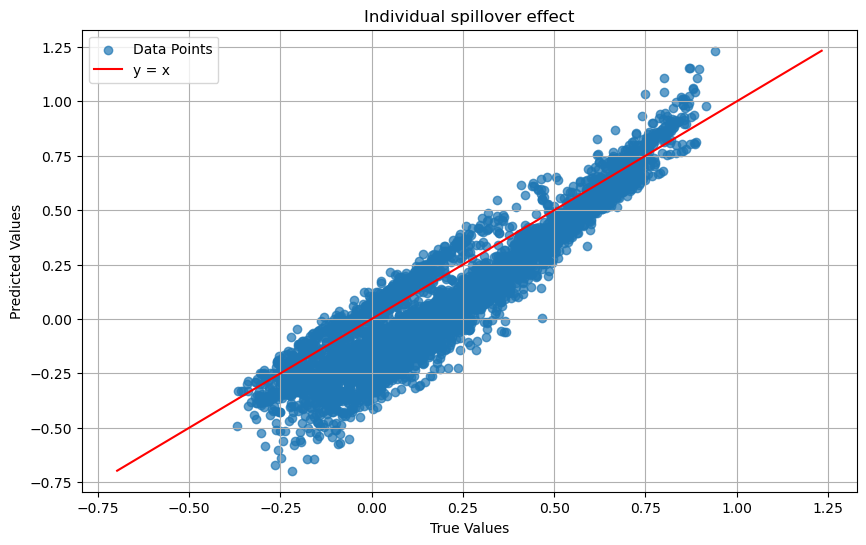

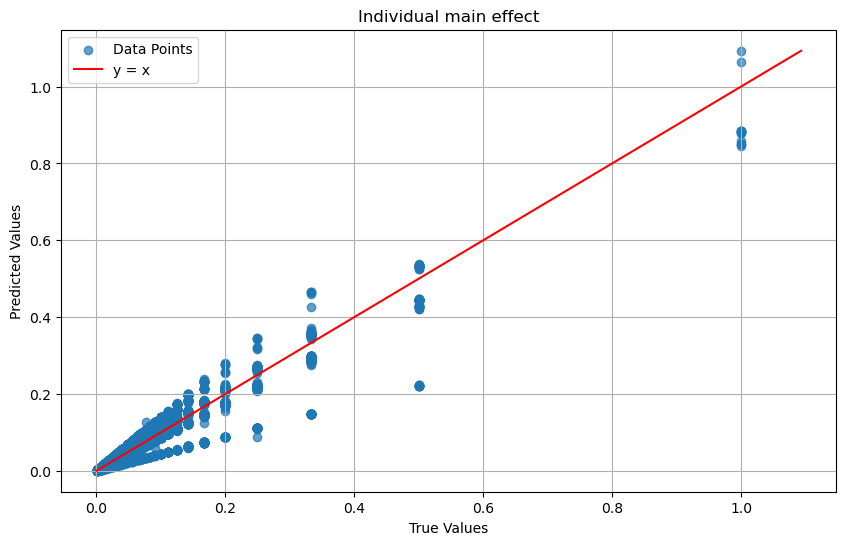

In [23]:
# Use attention FitResult for predicted attention if needed
# Spillover predictions are in fr_a.pred
# If predicted attention weights are needed, call model.predict
with torch.no_grad():
  W_pred, _ = fr_a.model.cpu().predict(torch.tensor(X, dtype=torch.float32), nbrs_idx, torch.tensor(t, dtype=torch.float32))
IME_est, ISE_est, ITE_est = compute_effect(W_pred, A)
print("Proposed: training set")
Result_train=compute_metric(IME, ISE, ITE, IME_est, ISE_est, ITE_est,printing=True)

with torch.no_grad():
  W_pred_test, _ = fr_a.model.predict(torch.tensor(X_test, dtype=torch.float32), nbrs_idx_test, torch.tensor(t_test, dtype=torch.float32))
IME_est_test, ISE_est_test, ITE_est_test = compute_effect(W_pred_test, A_test)
print("Proposed: testing set")
Result_test=compute_metric(IME_test, ISE_test, ITE_test, IME_est_test, ISE_est_test, ITE_est_test,printing=True)

plot_true_vs_pred(ISE,ISE_est,title_name="Individual spillover effect")
plot_true_vs_pred(IME,IME_est,title_name="Individual main effect")

In [ ]:
print(np.mean(ISE)-np.mean(ISE_est))
# print(np.mean(ISE_est))
print(np.mean(IME_test)-np.mean(IME_est_test))
print(np.mean(ITE)-np.mean(ITE_est))

0.026030019
0.001809841
0.026530582
